# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import warnings
import visdom
warnings.filterwarnings("ignore")

In [11]:
DATA_PATH = './cifar10-data'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,
                                        download=True, transform=transform)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = data.DataLoader(trainset, batch_size=4, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Visualize Images

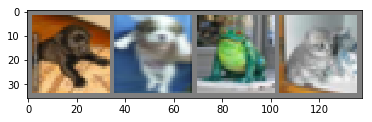

  dog   dog  frog   cat


In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_subset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
print('Total Train Images: ', len(train_subset_loader)*train_subset_loader.batch_size)
print('Total Test Images: ', len(testloader)*testloader.batch_size)

Total Train Images:  100
Total Test Images:  10000


This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Evaluation of the training procedure may be difficult because of the low number of labeled data we are using for the model training. We may have quite a hard time resolving overfitting problems: we have few gold data.

As seen in the class, solutions exists:
* We can use semi-supervized learning to try to make guesses about unlabeled train data
* Use transfer learning, and just fine-tune our model without the need of a huge great dataset
* Weak supervision or traditional supervision are also existing solutions, but we will not use them as they involve to ask for a new labelling round, even at higher/abstract level.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

###### Adapted from Kuanglio's Implementation : https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))

##### Utils : https://github.com/kuangliu/pytorch-cifar/blob/master/utils.py

In [20]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

term_width = 1
TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

#### Adapted from main https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os



total_epochs = 20
learning_rate=0.01
try_cuda=False

device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data Transformation
transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
 #   transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
#    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=10, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')

net = ResNet18()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_subset_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(train_subset_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    return (train_loss/(batch_idx+1)), 100.*correct/total
        

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
                
    return (test_loss/(batch_idx+1)), 100.*correct/total
                            
            
def train_resnet(total_epochs):
    
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    epoch_list = list(range(total_epochs))
            
    for epoch in range(start_epoch, start_epoch+total_epochs):
        train_loss, train_accuracy = train(epoch)
        test_loss, test_accuracy = test(epoch)
            
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
            
        test_loss_list.append(train_loss)
        test_accuracy_list.append(train_accuracy)
            
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list = train_resnet(total_epochs)

Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
 [==========================================================>......]  Step: 487ms | Tot: 4s760ms | Loss: 2.336 | Acc: 17.000% (17/100) 10/10 
 [=============================================================>...]  Step: 3s659ms | Tot: 1m8s | Loss: 2.318 | Acc: 10.000% (1000/10000) 20/20 0 
Saving..

Epoch: 1
 [==========================================================>......]  Step: 548ms | Tot: 5s248ms | Loss: 2.317 | Acc: 18.000% (18/100) 10/10 
 [=============================================================>...]  Step: 3s478ms | Tot: 1m7s | Loss: 2.431 | Acc: 10.020% (1002/10000) 20/20   
Saving..

Epoch: 2
 [==========================================================>......]  Step: 508ms | Tot: 4s785ms | Loss: 2.356 | Acc: 19.000% (19/100) 10/10 
 [=============================================================>...]  Step: 3s680ms | Tot: 1m8s | Loss: 2.434 | Acc: 14.170% (1417/1000

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 20 | 98% | 23.190% |

## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

##### Kuanglio's Implementation : https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py

In [12]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

total_epochs = 20
learning_rate=0.01
try_cuda=False

device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data Transformation
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=10, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = VGG('VGG19')

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_subset_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(train_subset_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    return (train_loss/(batch_idx+1)), 100.*correct/total
        

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
                
    return (test_loss/(batch_idx+1)), 100.*correct/total
                            
def train_vgg(total_epochs):
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    epoch_list = list(range(total_epochs))
            
    for epoch in range(start_epoch, start_epoch+total_epochs):
        train_loss, train_accuracy = train(epoch)
        test_loss, test_accuracy = test(epoch)
            
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
            
        test_loss_list.append(train_loss)
        test_accuracy_list.append(train_accuracy)
            
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list

train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list = train_vgg(total_epochs)

Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
 [==========================================================>......]  Step: 481ms | Tot: 4s662ms | Loss: 2.502 | Acc: 13.000% (13/100) 10/10 
 [=============================================================>...]  Step: 2s86ms | Tot: 40s462ms | Loss: 2.306 | Acc: 10.000% (1000/10000) 20/20 
Saving..

Epoch: 1
 [==========================================================>......]  Step: 452ms | Tot: 4s315ms | Loss: 2.680 | Acc: 14.000% (14/100) 10/10 
 [=============================================================>...]  Step: 2s280ms | Tot: 40s908ms | Loss: 2.502 | Acc: 10.030% (1003/10000) 20/20 
Saving..

Epoch: 2
 [==========================================================>......]  Step: 587ms | Tot: 4s720ms | Loss: 3.079 | Acc: 13.000% (13/100) 10/10 
 [=============================================================>...]  Step: 2s110ms | Tot: 40s800ms | Loss: 35.348 | Acc: 10.310% (1

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   VGG19  | 20 | 24% | 12.15 |

I trained ResNet18 and VGG19 models. And for the suggested training method, ResNet18 is a better choice than VGG19, since it converges faster and achieves a better test accuracy as shown in the two tables.

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

#### Pretrained Model Used : ResNet50. Finetuning the last layer

In [17]:
import os
import time
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms

DATA_PATH = './cifar10-data'
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Data Transformation
transform_train = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

total_epochs=20
lr=0.01
try_cuda=False

device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Load the model based on ResNet50
resnet_based = torchvision.models.resnet50(pretrained='imagenet')
num_ftrs = resnet_based.fc.in_features
resnet_based.fc = nn.Linear(num_ftrs, len(classes))

resnet_based = resnet_based.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True


print(resnet_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(resnet_based.parameters(), lr=learning_rate, momentum=0.9)

def train_model(model, criterion, optimizer,epoch):
    since = time.time()
    print('\nEpoch: %d' % epoch)
    
    #set model to trainable
    model.train()
    train_loss = 0
    
    correct = 0
    total = 0

    # Iterate over data.
    for i, data in enumerate(train_subset_loader):
        inputs , labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
          
        with torch.set_grad_enabled(True):
            outputs  = model(inputs)
            loss = criterion(outputs, labels)
            
            

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        print('{} Loss: {:.4f}'.format('train', train_loss / len(train_subset_loader)))
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        print('Train Accuracy: ', (100*correct)/total)
          
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

def test_model(model,epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc

#-----------------------------------------------------------------------------------

def main(total_epochs):
    for epoch in range(start_epoch, start_epoch+total_epochs):
        train_model(resnet_based, criterion, optimizer_ft,epoch)
        test_model(resnet_based,epoch)
        
main(total_epochs)

Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequen

train Loss: 9.3712
Train Accuracy:  10.0
train Loss: 18.2543
Train Accuracy:  15.0
train Loss: 27.3396
Train Accuracy:  15.0
train Loss: 37.4462
Train Accuracy:  15.0
train Loss: 47.6611
Train Accuracy:  12.0
Training complete in 0m 38s
 [=============================================================>...]  Step: 1s877ms | Tot: 36s495ms | Loss: 2.392 | Test Acc: 11.880% (1188/10000) 20/20 
Saving..

Epoch: 1
train Loss: 7.4992
Train Accuracy:  30.0
train Loss: 16.8081
Train Accuracy:  22.5
train Loss: 24.6799
Train Accuracy:  28.333333333333332
train Loss: 32.1864
Train Accuracy:  32.5
train Loss: 39.3928
Train Accuracy:  34.0
Training complete in 0m 39s
 [=============================================================>...]  Step: 2s81ms | Tot: 39s721ms | Loss: 2.392 | Test Acc: 11.880% (1188/10000) 20/20 

Epoch: 2
train Loss: 3.6204
Train Accuracy:  80.0
train Loss: 6.7761
Train Accuracy:  80.0
train Loss: 10.5067
Train Accuracy:  73.33333333333333
train Loss: 12.7025
Train Accuracy:  76

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet50-Pretrained  | 5 | 100% | 11.88% |

Although I trained the model for 20 epochs but training accuracy reached 100% on the 5th Epoch.

## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

###### Downloaded DCGAN Pretrained Model on CIFAR100 : https://github.com/csinva/pytorch_gan_pretrained/tree/master/cifar100_dcgan_grayscale/weights

###### Code Adapted from : https://github.com/pytorch/examples/blob/master/dcgan/main.py 

##### Note : We only need the discriminator (and not the generator) of DCGAN for feature extraction on CIFAR10 Dataset. And then SVM based supervised model is used for classification of the results.

In [4]:
import os
import random
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from sklearn import svm
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np


batchSize=20  #128 #input batch size
imageSize= 32  #the height / width of the input image to network
nz=256  #size of the latent z vector
ngf=128  # Starting Number of Filters in Generator
ndf=128  # Starting Number of Filters in Discriminator
nc = 1  # Number of Channels

cudnn.benchmark = True
discriminator_weight_path = './netD_epoch_299.pth'

##### Discriminator Structure of the DCGAN

In [6]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        #self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(0))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)
    
    def get_features(self, input):
        
        out1 = self.main[0](input)
        out_conv1 = self.main[1](out1)
        
        out2 = self.main[2](out_conv1)
        out3 = self.main[3](out2)
        out_conv2 = self.main[4](out3)
        
        
        out4 = self.main[5](out_conv2)
        out5 = self.main[6](out4)
        out_conv3 = self.main[7](out5)
        
        out6 = self.main[8](out_conv3)
        out7 = self.main[9](out6)
        out_conv4 = self.main[10](out7)
        
        out8 = self.main[11](out_conv4)
        out_conv5 = self.main[12](out8)

        max_pool1 = nn.MaxPool2d(int(out_conv1.size(2) / 4))
        max_pool2 = nn.MaxPool2d(int(out_conv2.size(2) / 4))
        max_pool3 = nn.MaxPool2d(int(out_conv3.size(2) / 4))
        # max_pool4 = nn.MaxPool2d(int(out_conv4.size(2) / 4))

        vector1 = max_pool1(out_conv1).view(input.size(0), -1).squeeze(1)
        vector2 = max_pool2(out_conv2).view(input.size(0), -1).squeeze(1)
        vector3 = max_pool3(out_conv3).view(input.size(0), -1).squeeze(1)
        # vector4 = max_pool4(out_conv4).view(input.size(0), -1).squeeze(1)

        return torch.cat((vector1, vector2, vector3), 1)

#### Feature Extraction using Discriminator of DCGAN + SVM Classifier

In [15]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
                               transforms.Resize(imageSize),
                               transforms.CenterCrop(imageSize),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])

transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=100, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Initialize a Discriminator
netD = Discriminator()

for name, param in netD.named_parameters():
    if param.requires_grad:
        print(name,param.shape)

netD.load_state_dict(torch.load(discriminator_weight_path))
print(netD)

netD.cuda()

netD.eval()

input = torch.FloatTensor(batchSize, 3, imageSize, imageSize).cuda()
train_features = np.array([])
train_labels = np.array([])

test_features = np.array([])
test_labels = np.array([])

from sklearn import svm

#Get training Set Features
for i, data in enumerate(train_subset_loader):
    imgs, label = data
    imgs = imgs.cuda()
    input.resize_as_(imgs).copy_(imgs)
    input_v = Variable(input)

    feature = netD.get_features(input_v)
    feature = feature.data.cpu().numpy()
    feature = feature.astype(np.float16)
        
    if train_features.size == 0:
        train_features = feature
        train_labels = label
    else:
        train_features = np.concatenate((train_features, feature), axis=0)
        train_labels = np.concatenate((train_labels, label), axis=0)
        
#Get Validation Set Features
for i, data in enumerate(testloader):
    imgs, label = data
    imgs = imgs.cuda()
    input.resize_as_(imgs).copy_(imgs)
    input_v = Variable(input)

    feature = netD.get_features(input_v)
    feature = feature.data.cpu().numpy()
    feature = feature.astype(np.float16)
        
    if test_features.size == 0:
        test_features = feature
        test_labels = label
    else:
        test_features = np.concatenate((test_features, feature), axis=0)
        test_labels = np.concatenate((test_labels, label), axis=0)
        
#-----------------------------------------------

print('train_feature shape', train_features.shape)
print('train_labels shape', train_labels.shape)

print('test_feature shape', test_features.shape)
print('test_labels shape', test_labels.shape)

print('train svm')
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(train_features, train_labels)
    
print('predict svm')
test_labels = test_labels.squeeze()
predicted_test_labels = clf.predict(test_features)
predicted_train_labels = clf.predict(train_features)

test_labels = test_labels.data.numpy()
train_labels = train_labels.data.numpy()

# Compute Test Accuracy
a = predicted_test_labels == test_labels
test_accuracy = np.sum(predicted_test_labels == test_labels) / len(test_labels)
print('svm results: %.4f Test Accuracy'%test_accuracy )

# Compute Train Accuracy
a = predicted_train_labels == train_labels
train_accuracy = np.sum(predicted_train_labels == train_labels) / len(train_labels)
print('svm results: %.4f Train accuracy'%train_accuracy)

Files already downloaded and verified
Files already downloaded and verified
main.0.weight torch.Size([64, 1, 4, 4])
main.2.weight torch.Size([128, 64, 4, 4])
main.3.weight torch.Size([128])
main.3.bias torch.Size([128])
main.5.weight torch.Size([256, 128, 4, 4])
main.6.weight torch.Size([256])
main.6.bias torch.Size([256])
main.8.weight torch.Size([512, 256, 4, 4])
main.9.weight torch.Size([512])
main.9.bias torch.Size([512])
main.11.weight torch.Size([1, 512, 2, 2])
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momen

#### Feature Extraction from DCGAN

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Pretrained-DCGAN+SVM  | 290 (Pretrained DCGAN) | 41% | 10.09% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

These data augmentation on extremely small images of size 32x32 can cause many defects.

* Aliasing is most likely to appear in the transformed data. However this could be partly mitigated with an anti aliasing filter;

* When we come to scaling, translation or non-square rotation, we will face the big issue of lack of pixel. When performing a non-square rotation,  we will have to zoom into the image in order not to have dark spots on the corners, but with that few pexels, we may reconstruct non recognizable images. Zooming is not everything, we will have to resize the image into 32*32 dimension, using interpolation. We will have to duplicate pixels and facing an even bigger pixelisation. To adress such problem, we can apply gaussian filters to our images in order to smooth the low resolution. We could also try to refine the image quality using GANs

* Scaling effects reduces the resolution of the image and this could be extremely harmful. To get rid of this, we could use sub-pixel methods.

## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

##### Question 3 (with Data Augmentation) : ResNet with Transformations 

In [21]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

    
#-------------------------Train--------------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


total_epochs = 20
learning_rate=0.01
try_cuda=False

device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data Transformation
transform_train = transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=10, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')

net = ResNet18()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_subset_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(train_subset_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    return (train_loss/(batch_idx+1)), 100.*correct/total
        

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
                
    return (test_loss/(batch_idx+1)), 100.*correct/total
                            
            
def train_resnet(total_epochs):
    
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    epoch_list = list(range(total_epochs))
            
    for epoch in range(start_epoch, start_epoch+total_epochs):
        train_loss, train_accuracy = train(epoch)
        test_loss, test_accuracy = test(epoch)
            
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
            
        test_loss_list.append(train_loss)
        test_accuracy_list.append(train_accuracy)
            
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list
            
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list = train_resnet(total_epochs)

Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
 [==========================================================>......]  Step: 482ms | Tot: 4s666ms | Loss: 2.440 | Acc: 8.000% (8/100) 10/10 
 [=============================================================>...]  Step: 3s380ms | Tot: 1m5s | Loss: 2.324 | Acc: 10.000% (1000/10000) 20/20 0 
Saving..

Epoch: 1
 [==========================================================>......]  Step: 562ms | Tot: 4s852ms | Loss: 2.500 | Acc: 13.000% (13/100) 10/10 
 [=============================================================>...]  Step: 3s476ms | Tot: 1m5s | Loss: 2.374 | Acc: 10.690% (1069/10000) 20/20 0 
Saving..

Epoch: 2
 [==========================================================>......]  Step: 565ms | Tot: 5s406ms | Loss: 2.309 | Acc: 17.000% (17/100) 10/10 
 [=============================================================>...]  Step: 3s465ms | Tot: 1m6s | Loss: 3.735 | Acc: 10.890% (1089/10000)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 (with Data Augmentation)  | 20 | 44% | 12.6% |

##### Question 4 (with Data Augmentation) : VGG with Tranformations

In [24]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
#-------------------------TRAIN--------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

total_epochs = 20
learning_rate=0.01
try_cuda=False

device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data Transformation
transform_train = transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.05, saturation=0.05, hue=0.05),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

#Define Valid Indices
subset_indices = list(range(100))

#Using Torch Subset DataLoader to Load the valid indices
train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=10, sampler=data.SubsetRandomSampler(subset_indices))

testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
net = VGG('VGG19')

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_subset_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(train_subset_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    return (train_loss/(batch_idx+1)), 100.*correct/total
        

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
                
    return (test_loss/(batch_idx+1)), 100.*correct/total
                            
def train_vgg(total_epochs):
    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    epoch_list = list(range(total_epochs))
            
    for epoch in range(start_epoch, start_epoch+total_epochs):
        train_loss, train_accuracy = train(epoch)
        test_loss, test_accuracy = test(epoch)
            
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
            
        test_loss_list.append(train_loss)
        test_accuracy_list.append(train_accuracy)
            
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list
        
train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, epoch_list = train_vgg(total_epochs)

Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
 [==========================================================>......]  Step: 433ms | Tot: 4s434ms | Loss: 2.554 | Acc: 17.000% (17/100) 10/10 
 [=============================================================>...]  Step: 1s997ms | Tot: 38s805ms | Loss: 2.287 | Acc: 10.010% (1001/10000) 20/20 
Saving..

Epoch: 1
 [==========================================================>......]  Step: 527ms | Tot: 4s598ms | Loss: 2.846 | Acc: 9.000% (9/100) 10/10 
 [=============================================================>...]  Step: 2s178ms | Tot: 40s919ms | Loss: 33.533 | Acc: 10.960% (1096/10000) 20/20 
Saving..

Epoch: 2
 [==========================================================>......]  Step: 513ms | Tot: 4s510ms | Loss: 2.613 | Acc: 9.000% (9/100) 10/10 
 [=============================================================>...]  Step: 2s30ms | Tot: 40s971ms | Loss: 60.702 | Acc: 12.320% (1232

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   VGG19 (with data augmentation)  | 20 | 20% | 12.61% |

## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

##### Source : https://www.kymat.io/gallery_2d/cifar_resnet.html#sphx-glr-gallery-2d-cifar-resnet-py

In [27]:
import torch.optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from kymatio import Scattering2D
import torch
import argparse
#import kymatio.datasets as scattering_datasets
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Scattering2dResNet(nn.Module):
    def __init__(self, in_channels,  k=2, n=4, num_classes=10):
        super(Scattering2dResNet, self).__init__()
        self.inplanes = 16 * k
        self.ichannels = 16 * k
        self.K = in_channels
        self.init_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels, eps=1e-5, affine=False),
            nn.Conv2d(in_channels, self.ichannels,
                  kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.ichannels),
            nn.ReLU(True)
        )

        self.layer2 = self._make_layer(BasicBlock, 32 * k, n)
        self.layer3 = self._make_layer(BasicBlock, 64 * k, n)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc = nn.Linear(64 * k * 4, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), self.K, 8, 8)
        x = self.init_conv(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



def train(model, device, train_subset_loader, optimizer, epoch, scattering):
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_subset_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(scattering(data))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_subset_loader.dataset),
                100. * batch_idx / len(train_subset_loader), loss.item()))
        
        print('Train Accuracy: ', (100*correct)/total)
        
        
def test(model, device, testloader, scattering):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(scattering(data))
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

def main():
    """Train a simple Hybrid Resnet Scattering + CNN model on CIFAR.

        scattering 1st order can also be set by the mode
        Scattering features are normalized by batch normalization.
        The model achieves around 88% testing accuracy after 10 epochs.

        scatter 1st order +
        scatter 2nd order + linear achieves 70.5% in 90 epochs

        scatter + cnn achieves 88% in 15 epochs

    """
    description='CIFAR scattering  + hybrid examples'
    mode = 1 #scattering 1st or 2nd order
    width = 2 #width factor for resnet

    try_cuda=False
    device = 'cuda' if torch.cuda.is_available() and try_cuda else 'cpu'

    if mode == 1:
        scattering = Scattering2D(J=2, shape=(32, 32), max_order=1)
        K = 17*3
    else:
        scattering = Scattering2D(J=2, shape=(32, 32))
        K = 81*3
    if try_cuda:
        scattering = scattering.to(device)

    model = Scattering2dResNet(K, width).to(device)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    #--------------------------------------------------------------------------
    # Data Transformation
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)

    #Define Valid Indices
    subset_indices = list(range(100))

    #Using Torch Subset DataLoader to Load the valid indices
    train_subset_loader = torch.utils.data.DataLoader(trainset, batch_size=10, sampler=data.SubsetRandomSampler(subset_indices))

    testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    #------------------------------------------------------------------------------------------

    # Optimizer
    lr = 0.1
    num_epoch = 20
    
    print('Total Train Images: ', len(train_subset_loader)*train_subset_loader.batch_size)
    print('Total Test Images: ', len(testloader)*testloader.batch_size)
    for epoch in range(0, num_epoch):
        if epoch%20==0:
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                                        weight_decay=0.0005)
            lr*=0.2

        train(model, device, train_subset_loader, optimizer, epoch+1, scattering)
        test(model, device, testloader, scattering)

main()

Files already downloaded and verified
Files already downloaded and verified
Total Train Images:  100
Total Test Images:  10000
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.214156
Train Accuracy:  10.0
Train Epoch: 1 [10/50000 (10%)]	Loss: 5.080067
Train Accuracy:  15.0
Train Epoch: 1 [20/50000 (20%)]	Loss: 4.368468
Train Accuracy:  13.333333333333334
Train Epoch: 1 [30/50000 (30%)]	Loss: 3.858758
Train Accuracy:  12.5
Train Epoch: 1 [40/50000 (40%)]	Loss: 11.150679
Train Accuracy:  14.0
Train Epoch: 1 [50/50000 (50%)]	Loss: 11.291357
Train Accuracy:  15.0
Train Epoch: 1 [60/50000 (60%)]	Loss: 11.093459
Train Accuracy:  14.285714285714286
Train Epoch: 1 [70/50000 (70%)]	Loss: 7.149952
Train Accuracy:  12.5
Train Epoch: 1 [80/50000 (80%)]	Loss: 3.564714
Train Accuracy:  13.333333333333334
Train Epoch: 1 [90/50000 (90%)]	Loss: 3.822342
Train Accuracy:  13.0

Test set: Average loss: 275.0612, Accuracy: 1341/10000 (13.41%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.231939
Train Accuracy:  0.0
Train Ep

Train Epoch: 11 [20/50000 (20%)]	Loss: 2.273019
Train Accuracy:  3.3333333333333335
Train Epoch: 11 [30/50000 (30%)]	Loss: 2.022736
Train Accuracy:  12.5
Train Epoch: 11 [40/50000 (40%)]	Loss: 2.354164
Train Accuracy:  16.0
Train Epoch: 11 [50/50000 (50%)]	Loss: 2.175894
Train Accuracy:  18.333333333333332
Train Epoch: 11 [60/50000 (60%)]	Loss: 2.250979
Train Accuracy:  17.142857142857142
Train Epoch: 11 [70/50000 (70%)]	Loss: 2.121816
Train Accuracy:  16.25
Train Epoch: 11 [80/50000 (80%)]	Loss: 2.278606
Train Accuracy:  16.666666666666668
Train Epoch: 11 [90/50000 (90%)]	Loss: 2.432130
Train Accuracy:  17.0

Test set: Average loss: 2.4214, Accuracy: 1119/10000 (11.19%)

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.987909
Train Accuracy:  20.0
Train Epoch: 12 [10/50000 (10%)]	Loss: 2.242917
Train Accuracy:  10.0
Train Epoch: 12 [20/50000 (20%)]	Loss: 2.474226
Train Accuracy:  6.666666666666667
Train Epoch: 12 [30/50000 (30%)]	Loss: 2.088539
Train Accuracy:  10.0
Train Epoch: 12 [40/50000 (4

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Scattering Transform + ResNet  | 20 | 20% | 11.67% |

# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

I did not attempt this question.

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In this task, we go over various techniques to address the problem of small datasets. Although in practice, deep-learning methods are extremely data hungry because of their high number of trainable parameters. However in this task, we dive into some of the techniques which can boost the performance of deep neural networks on small and mini datasets. The considered dataset in this task is a subset of 100 samples from CIFAR-10. CIFAR-10 is a widely used benchmark in computer vision and deep learning.


Initially we compare the performance of VGG19 and ResNet18 architectures on our dataset. I trained both the models for 20 epochs and obtained accuracy of 23% on the test dataset using ResNet whereas obtained an accuracy of 12.15% using the VGG19 architecture. This is certainly down to the design of ResNets, where there skip connections providing high speed highway for gradient flow and therefore improve performance.


After this we had to use a pretrained model on ImageNet and finetune it on our dataset. For this I used ResNet50 Architecure and finetuned the last layer. Amazingly just for 5 epochs, the performance on the training dataset reached 100% whereas the performance on the test dataset was quite poor numerically being 11.86%. We conclude from this that finetune (transfer learning) is an extremely effective technique which can help in dealing with mini datasets. And depending on the amount of data we have, we can choose train last layer or the last few layers etc.

The other task involving pretrained model was to use a pretrained DCGAN model. After struggling alot, I was able to find a pretrained discriminator (trained for 290 epochs) for the DCGAN model on CIFAR100 dataset (link given just below question 6). I used the discriminator to extract the vector representations for the images in our training and test samples. On these vector representations, I trained a supervised SVM model and obtained an accuracy of 10.09% on the test dataset, which is not very good. Certainly a better discriminator can increase the performance. Through this task we learnt that using GANs as feature extractors for images can be useful when we have small data problems.

The next notion involved using data augmentation and transformation methods. I augmented the dataset with a mix of affine transformations and color jittering in the HSV color space. And then used the same VGG19 and ResNet18 for training. Interestingly the performance of VGG19 and ResNet18 dropped on the test dataset (till 20 epochs atleast). I believe that the size of images in CIFAR10 is $32\times32$ and applying data augmentation must have caused distortion, which led to the loss of performance. I believe training the model for more number of epochs can be helpful.

Finally we had to train an end to end pipeline involving scattering transform and a ResNet based architecture. The idea is that scattering transforms preserves most of the signal information needed for classification while
substantially reducing the spatial resolution and total signal size. I trained this pipeline for 20 epochs and obtained a test accuracy of 11.67%. An advantage of using scattering transforms as a base for deep nets is that it delivers substantial  improvements in  the  inference  speed and training memory consumption compared to
models trained directly on the input images.


The following figure summarizes the obtained results:

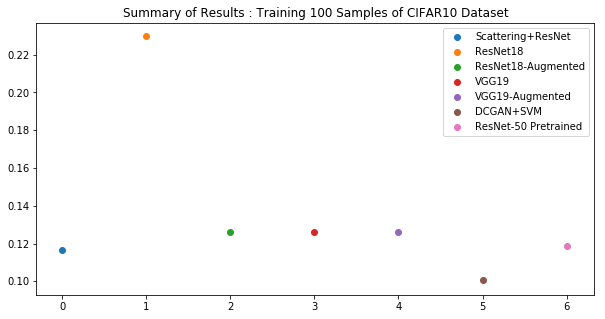

In [29]:
import matplotlib.pyplot as plt

models = {
    "Scattering+ResNet": [20, 0.20, 0.1167], 
    "ResNet18": [20,0.98, .23], 
    "ResNet18-Augmented": [20, 0.44, .1262], 
    "VGG19": [20, 0.24, .1262], 
    "VGG19-Augmented": [20, 0.20, .1261],  
    "DCGAN+SVM": [290, 1.0, 0.1009],  
    "ResNet-50 Pretrained": [5, 1.0, 0.1186]}



plt.figure(figsize=(10,5))
for i, (name, values) in enumerate(models.items()):
    plt.scatter(i, values[-1], label=name)
plt.legend()
plt.title("Summary of Results : Training 100 Samples of CIFAR10 Dataset")
plt.plot()
plt.show()